# Figure 8

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
from cmcrameri import cm

In [3]:
# My packages
from aeolus.calc import time_mean, wind_rot_div
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import subplot_label_generator
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
    use_style,
)

In [4]:
# Local modules
import mypaths
from commons import GLM_SUITE_ID, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs_p = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    if sim_label == "base":
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    # Cubes on pressure levels
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl_p[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

## Choose variables and perform calculations needed

Choose the pressure level.

In [8]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})

Perform the Helmholtz decomposition and store results in a `RESULTS` dictionary for each of the experiments. Also store the vertical wind velocity in the same dictionary.

In [9]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS[sim_label] = {}

    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run_p.coord.x.points
    RESULTS[sim_label]["lats"] = the_run_p.coord.y.points

    u = time_mean(runs_p[sim_label].u.extract(p_lev_constr1))
    v = time_mean(runs_p[sim_label].v.extract(p_lev_constr1))
    w = time_mean(runs_p[sim_label].w.extract(p_lev_constr1))

    RESULTS[sim_label].update(wind_rot_div(u, v))
    RESULTS[sim_label]["w"] = w
    del u, v, w

## Create a figure

Set display settings for the chosen variables.

In [10]:
WIND_CMPNT_META = {
    "total": {"title": "Total", "qk_ref_wspd": 60, "kw_plt": dict(color="#222222")},
    "div": {"title": "Divergent", "qk_ref_wspd": 10, "kw_plt": dict(color="C0")},
    "rot_zm": {"title": "Jet", "qk_ref_wspd": 60, "kw_plt": dict(color="C3")},
    "rot_eddy": {"title": "Eddy", "qk_ref_wspd": 30, "kw_plt": dict(color="C2")},
}

In [11]:
KW_W = dict(
    cmap=cm.vik,
    levels=linspace_pm1(10) * 5,
    extend="both",
)

KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

KW_QUIVER = dict(
    scale_units="inches",
    scale=200,
    # facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

Choose wind components to display with arrows.

In [12]:
winds_to_plot = ["rot_zm", "rot_eddy", "div"]

Assemble the figure.

In [13]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__rotdiv_{P_LEV1}hpa"

ncols = 2
nrows = len(winds_to_plot)

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(16, 12),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.add_artist(
        AnchoredText(
            r"Shading: vertical velocity [$\times 10^{-2}$ $m$ $s^{-1}$]",
            frameon=True,
            prop=dict(size="x-small"),
            loc="upper left",
        )
    )
for ax in axs[:, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    # if ax.get_subplotspec().is_first_col():
    ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for wind_key, axrow in zip(winds_to_plot, axs):
    wind_meta = WIND_CMPNT_META[wind_key]
    for (sim_label, sim_prop), ax in zip(SIM_LABELS.items(), axrow):
        ax.set_title(wind_meta["title"], **KW_AUX_TTL)
        if ax.get_subplotspec().is_first_row():
            ax.set_title(sim_prop["title"], **KW_MAIN_TTL)

        _u = RESULTS[sim_label][f"u_{wind_key}"]
        _v = RESULTS[sim_label][f"v_{wind_key}"]
        _p0 = ax.contourf(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            RESULTS[sim_label]["w"].data * 1e2,
            **{**KW_W, "cmap": cm.vik, "alpha": 0.75},
        )
        _p00 = ax.contour(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            RESULTS[sim_label]["w"].data * 1e2,
            levels=KW_W["levels"],
            colors="k",
            linewidths=0.5,
        )
        _clbl = ax.clabel(_p00, fmt="%.1f", fontsize="x-small")
        qk_ref_wspd = wind_meta["qk_ref_wspd"]
        _kw_quiv = {**KW_QUIVER, **{"scale": qk_ref_wspd * 4}}
        _q = ax.quiver(
            RESULTS[sim_label]["lons"][xsl],
            RESULTS[sim_label]["lats"][ysl],
            _u.data[ysl, xsl],
            _v.data[ysl, xsl],
            (_u.data[ysl, xsl] ** 2 + _v.data[ysl, xsl] ** 2) ** 0.5,
            norm=plt.Normalize(0, qk_ref_wspd),
            cmap=cm.imola,
            **_kw_quiv,
        )
        ax.quiverkey(
            _q,
            *(0.8, 1.025),
            qk_ref_wspd,
            rf"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
            **KW_QUIVERKEY,
        )
    _cbar0 = fig.colorbar(_q, ax=axrow, **KW_CBAR)
    _cbar0.ax.set_ylabel("Horizontal wind speed [$m$ $s^{-1}$]", **KW_CBAR_TTL)
plt.close()

# Show the figure

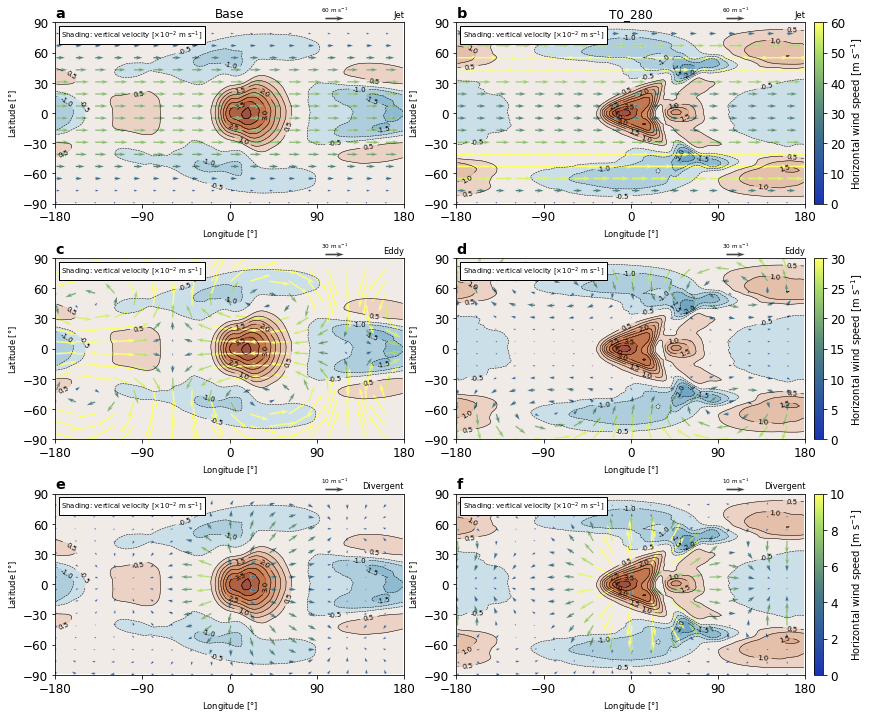

In [14]:
fig

* **Helmholtz decomposition of the horizontal wind at $300\,hPa$ in the (left) _Base_ (SJ regime) and (right) _T0\_280_ (DJ regime) simulations, corresponding to the wind field shown in Fig.~7a,b.**
* **The panels show (a, b) the zonal mean rotational component, (c, d) the eddy rotational component, (e, f) the divergent component. Note the different scaling of the each of the components.**
* **Also shown is the upward wind velocity (shading, $\times 10^{-2}$ $m$ $s^{-1}$).**

In [15]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_mean/ch111_mean__base_sens-t280k__rotdiv_300hpa.png
